# ASM Processing

'''
Contributors: Jia-Shen Tsai

Last Updated: 2023-12-13

When run, process the ASM and explor a bit
'''

In [1]:
import pandas as pd
import arcpy
# pip install geopandas
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import contextily as ctx

import os
from arcgis import GeoAccessor
import warnings

In [3]:
#pip install geopandas
#pip install contextily

In [ ]:
# # data inspection
# df = pd.read_json('../01_Data/01_Source/ASM/2023_11_12_14_45_11_107617.json')
# for i in df['location']:
#     print(i)

# # data subset 
# df_nc = df.query('name in ("Silver Meteor","Carolinian","Piedmont","Palmetto","Crescent")')
# df_nc.shape

# df_nc['current_timezone'].unique()

# # Extract latitude and longitude only from valid dictionaries
# def extract_coordinates(location):
#     if isinstance(location, dict):
#         return location.get('latitude'), location.get('longitude'), location.get('speed')
#    else:
#        return None, None, None

# %%capture --no-stdout
# df_nc[['latitude', 'longitude', 'speed']] = df_nc['location'].apply(extract_coordinates).apply(pd.Series)
# df_nc.head()

# sdf = GeoAccessor.from_xy(
#     df_nc,
#     x_column='longitude',
#     y_column='latitude'
# )

# #Create a geodataframe from the data
# gdf = gpd.GeoDataFrame(
#     data = sdf,
#     geometry = 'SHAPE',
#     crs = 4326)

In [10]:
gdf_county = gpd.read_file('../01_Data/01_Source/North_Carolina_State_and_County_Boundary_Polygons.zip')

In [17]:
# Use the warnings context manager to capture and suppress warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")  # Ignore all warnings
    # Define the folder path where JSON files are located
    json_folder = '//ns-gis.win.duke.edu/StudentData/2023-2024/ct325/2023_NSOE_Commuter_Rail/01_Data/01_Source/ASM'

    # Define the function to extract the lng, la, and speed only from valid dictionaries
    def extract_coordinates(location):
        if isinstance(location, dict):
            return location.get('latitude'), location.get('longitude'), location.get('speed')
        else:
            return None, None, None

    # Initialize an empty GeoDataFrame to store the combined data
    gdf_realop = gpd.GeoDataFrame()

    # Read and process each JSON file in the folder
    for filename in os.listdir(json_folder):
        if filename.endswith('.json'):
            json_filepath = os.path.join(json_folder, filename)

            # Read JSON file into a df
            df = pd.read_json(json_filepath)

            # Filter routes that pass nc and make lng, lat, speed to independent columns
            df_nc = df.query('name in ("Silver Meteor","Carolinian","Piedmont","Palmetto","Crescent")')
            df_nc[['latitude', 'longitude','speed']] = df_nc['location'].apply(extract_coordinates).apply(pd.Series)

            # Create a sdf
            sdf = GeoAccessor.from_xy(df_nc, x_column='longitude', y_column='latitude')

            # Create a gdf
            gdf = gpd.GeoDataFrame(data=sdf, geometry='SHAPE', crs=4326)

            # Clip the GeoDataFrame to the county boundary
            gdf_snap_nc = gpd.clip(gdf, gdf_county)

            # Append the clipped gdf to the combined gdf
            gdf_realop = pd.concat([gdf_realop, gdf_snap_nc], ignore_index=True)

# Remove duplicates based on name and location
gdf_realop = gdf_realop.drop_duplicates(subset=['name', 'latitude', 'longitude'])

gdf_realop.head()

UndefinedVariableError: name 'name' is not defined

In [18]:
gdf_realop

,train_id,railroad,origin_date,number,all_numbers,name,origin,destination,partial_train,last_updated,current_timezone,threshold,disruption,total_miles,location,stops,latitude,longitude,speed,SHAPE


In [ ]:
gdf_realop = gdf_realop.set_geometry('SHAPE')

In [ ]:
#Plot them with a base map
realop_plot = gdf_realop.to_crs(3857).plot(column='speed', legend=True)
ctx.add_basemap(realop_plot)

In [ ]:
# Export the geodataframe to a CSV file
pd.DataFrame(gdf_realop).to_csv(
    '../01_data/02_Processed/realopNov12.csv',
    index=False
)

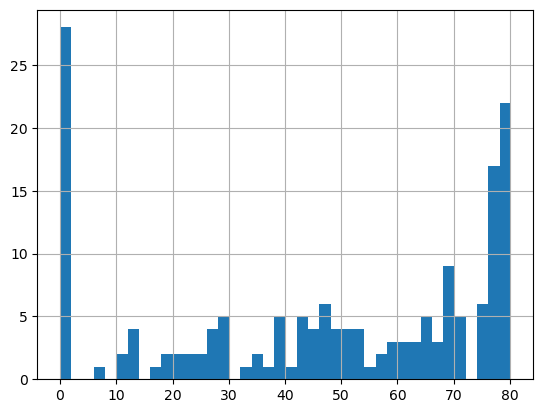

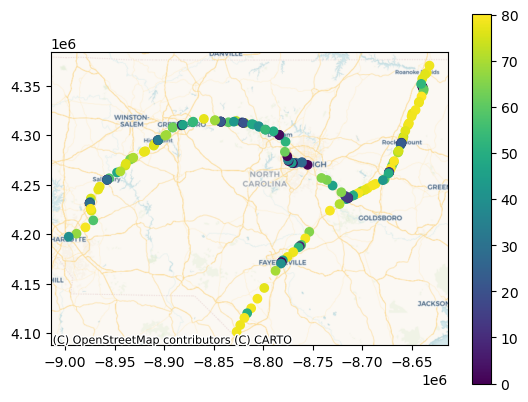

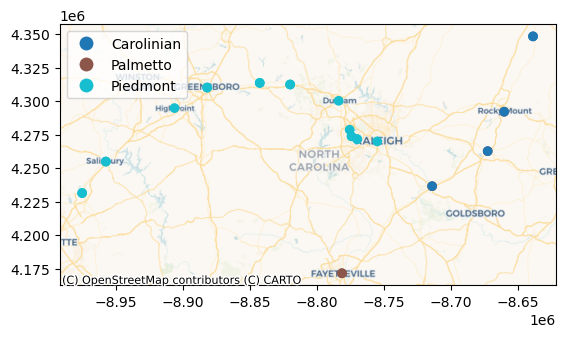

In [3]:
df_realop = pd.read_csv('../01_data/02_Processed/realopNov12.csv')
s = gpd.GeoSeries.from_wkt(df_realop.SHAPE)
gdf_realop = gpd.GeoDataFrame(
    data = df_realop,
    geometry = s,
    crs = 4326
)
gdf_realop = gdf_realop.drop(columns=['SHAPE'])
gdf_realop = gdf_realop.drop_duplicates(subset=['name', 'latitude', 'longitude'])

gdf_realop['speed'].hist(bins=40);

import contextily as ctx
#Plot them with a base map
realop_plot = gdf_realop.to_crs(3857).plot(column='speed', legend=True)
ctx.add_basemap(realop_plot,
               source=ctx.providers.CartoDB.Voyager)

potential_stop = gdf_realop.query('speed < 1')
potential_stop.shape

#Plot them with a base map
potentialStop_plot = potential_stop.to_crs(3857).plot(column='name', legend=True)
ctx.add_basemap(potentialStop_plot,
               source=ctx.providers.CartoDB.Voyager)